<div class="alert alert-block alert-info">
<font size="6"><b><center> Section 3</font></center>
<br>
<font size="6"><b><center> Practical Aspects of Building Deep Learning Models </font></center>
</div>

**In this example, we will illustrate the comparison between training and validation losses and regularization techniques using dropout and L2-norm regularization.**

<div class="alert alert-block alert-info">
</div>

# Notations for Regularization

Regularized objective function:

$ C = C_0 + \text{Penalty Term} $

where $C_0$ is the unregularized objective function

$L^2$ norm penalty term typically take the form of $ \frac{1}{2} ||w||^2_2 $

### Equation by equation

**Inputs to hidden layer 1**

$z_1(\mathbf{x}; \mathbf{w_1},b_1) = \sum_{j=1}^4 w_{1,j}^{(1)} x_j + b_1^{(1)}$


$z_2(\mathbf{x}; \mathbf{w_2},b_2) = \sum_{j=1}^4 w_{2,j}^{(1)} x_j + b_2^{(1)}$

$\vdots$

$z_6(\mathbf{x}; \mathbf{w_6},b_6) = \sum_{j=1}^4 w_{6,j}^{(1)} x_j + b_6^{(1)}$

where $j=1,2,3,4$ (in this example) is the index for the inputs

$h_k(\mathbf{x}; \mathbf{w_k},b_k) = g_1(z_k)$ where $k=1,2,\dots,6$ is the index for the hidden units


**Hidden layer 1 to output**

$y_1 = g_2 \left( \sum_{k=1}^6 w_{1,k}^{(2)} + b_1^{(2)} \right)$

$y_2 = g_2 \left( \sum_{k=1}^6 w_{2,k}^{(2)} + b_2^{(2)} \right)$

### Sequential layerwise architecture

First layer:
$$ \mathbf{h}^{(1)} = g^{(1)} \left(\mathbf{W}^{(1)} \mathbf{x} + \mathbf{b}^{(1)}  \right) $$

Second layer:
$$ \mathbf{h}^{(2)} = g^{(2)} \left(\mathbf{W}^{(2)T} \mathbf{h}^{(1)} + \mathbf{b}^{(2)}  \right) $$



$\vdots$


$l^{th}$ layer:
$$ \mathbf{h}^{(l)} = g^{(l)} \left(\mathbf{W}^{(l)T} \mathbf{h}^{(l-1)} + \mathbf{b}^{(l)}  \right) $$



<div class="alert alert-block alert-info">
</div>

# Example 1: Feedforward Network Without Regularization

## Simulate and Visualize Data

The output is related to the input using the following function

$$y_i = 3x_{i,1} + x^2 exp(x_{i,1}) + \epsilon_i$$

where $\epsilon$ is an independently and identically distributed (i.i.d.) random variable and $i = 1,2,\dots,n$ is an index of examples (or observations)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

n = 200 # number of examples (or observations)

# Generate a set of n random numbers from a standard normal distribution
epsilon = np.random.randn(n)

# Generate a set of n random numbers from a uniform[0,1] distribution; name it x1
# and create another variable, which we name x2, from x1
x1 = np.random.uniform(0,1,n)
x2 = 1. / (1. + np.exp(-np.power(x1,3))) + 0.5*epsilon
x3 = np.random.randn(n)

X = pd.DataFrame({'x1':x1, 'x2':x2})

# Create the data generating mechanism
y = 3*x1 + np.power(x1,2)*np.exp(x1) + 0.8*x2 + 0.5*x3 + epsilon

## Split the data into a Training and Validation Set

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)

### Basic Descriptive Analysis

In [3]:
print(X_train.describe().T.round(4), "\n")
print(pd.DataFrame({'y':y_train}).describe().T.round(4))

    count    mean     std     min     25%     50%     75%     max
x1  100.0  0.5113  0.2800  0.0081  0.2580  0.5326  0.7645  0.9993
x2  100.0  0.5278  0.5049 -0.6253  0.1937  0.5709  0.8746  1.8078 

   count    mean     std     min     25%     50%     75%     max
y  100.0  2.6217  2.2474 -1.5981  0.9424  2.7567  4.0442  9.0948


In [4]:
# Correlation between x1 and x2 in the training set
np.corrcoef(X_train.iloc[:,0], X_train.iloc[:,1])[0][1].round(2)

0.09

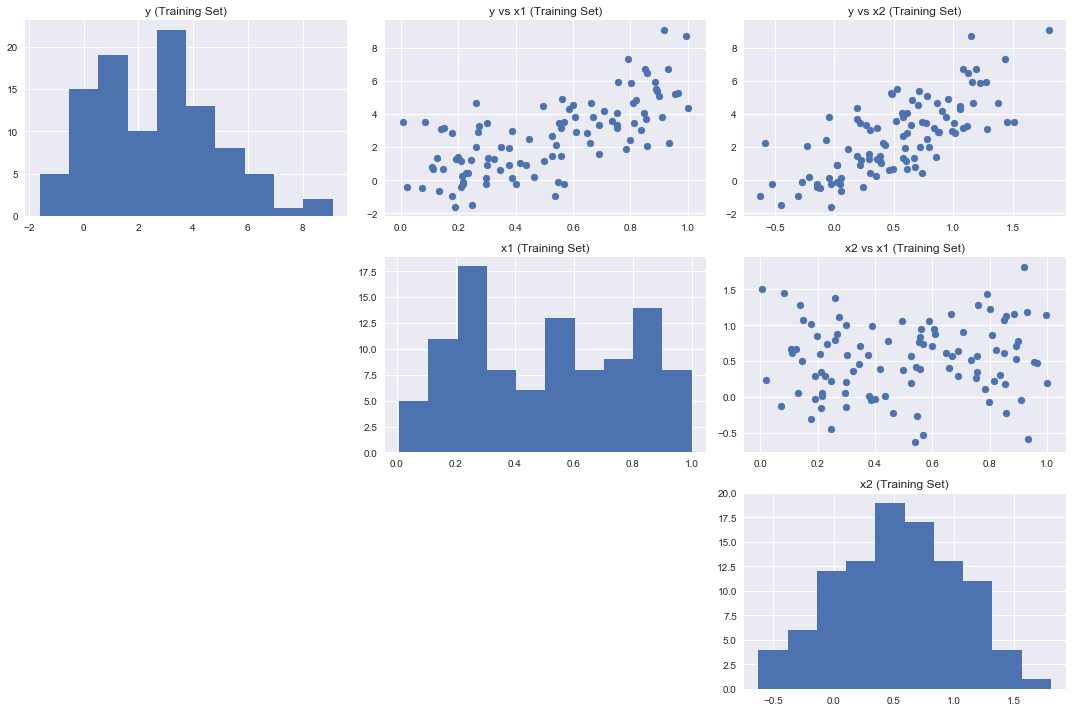

In [5]:
fig = plt.figure(figsize=(15,10))

plt.subplot(3, 3, 1)
plt.hist(y_train)
plt.title("y (Training Set)")

plt.subplot(3, 3, 2)
plt.scatter(X_train.iloc[:,0], y_train)
plt.title("y vs x1 (Training Set)")

plt.subplot(3, 3, 3)
plt.scatter(X_train.iloc[:,1], y_train)
plt.title("y vs x2 (Training Set)")

plt.subplot(3, 3, 5)
plt.hist(X_train.iloc[:,0])
plt.title("x1 (Training Set)")

plt.subplot(3, 3, 6)
plt.scatter(X_train.iloc[:,0], X_train.iloc[:,1])
plt.title("x2 vs x1 (Training Set)")

plt.subplot(3, 3, 9)
plt.hist(X_train.iloc[:,1])
plt.title("x2 (Training Set)")

plt.tight_layout()

<div class="alert alert-block alert-warning">
Note: Before training, `numpy array` and `pandas dataframe` need to be converted to `PyTorch's tensors`
</div>

In [6]:
# convert numpy array to tensor in shape of input size
import torch 

X_train_ts = torch.from_numpy(X_train.values.reshape(-1,2)).float()
y_train_ts = torch.from_numpy(y_train.reshape(-1,1)).float()

X_test_ts = torch.from_numpy(X_test.values.reshape(-1,2)).float()
y_test_ts = torch.from_numpy(y_test.reshape(-1,1)).float() # y_test is a numpy array

In [7]:
print("X_train_ts is of %s type" %type(X_train_ts))
print("y_train_ts is of %s type" %type(y_train_ts))
print("X_test_ts is of %s type" %type(X_test_ts))
print("y_test_ts is of %s type" %type(y_test_ts))

X_train_ts is of <class 'torch.Tensor'> type
y_train_ts is of <class 'torch.Tensor'> type
X_test_ts is of <class 'torch.Tensor'> type
y_test_ts is of <class 'torch.Tensor'> type


In [8]:
print(X_train_ts.shape)
print(y_train_ts.shape)
print(X_test_ts.shape)
print(y_test_ts.shape)

torch.Size([100, 2])
torch.Size([100, 1])
torch.Size([100, 2])
torch.Size([100, 1])


In [9]:
# First 5 rows of tensor X
print("First 5 rows of tensor X_train_ts", "\n",  X_train_ts[:5], "\n")
print("First 5 rows of tensor y_train_ts", "\n",  y_train_ts[:5], "\n")

First 5 rows of tensor X_train_ts 
 tensor([[0.5519, 0.7696],
        [0.2090, 0.6015],
        [0.2457, 0.2234],
        [0.1453, 0.4958],
        [0.4352, 0.0201]]) 

First 5 rows of tensor y_train_ts 
 tensor([[3.4655],
        [1.1526],
        [1.2246],
        [0.6834],
        [0.9511]]) 



## Define a Feed-forward network with 1 hidden layers

In [10]:
# Let's confirm the dimensions of the inputs and output
print("train_size: ", len(X_train_ts), "\n")
print("X shape:", X_train_ts.shape, "\n")
print("y shape:", y_train_ts.shape, "\n")
print(X_train_ts.shape[1])

train_size:  100 

X shape: torch.Size([100, 2]) 

y shape: torch.Size([100, 1]) 

2


In [11]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class ffNet(nn.Module):
    """
    D_in: input dimension
    D_h1: dimension of hidden layer 1
    D_out: output dimension
    """
    
    def __init__(self, D_in, D_h1, D_h2, D_out):
        super(ffNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, D_h1)  # torch.nn.Linear(1, 4)
        self.linear2 = torch.nn.Linear(D_h1, D_out) # torch.nn.Linear(4, 1)

    def forward(self, x):
        h1 = F.relu(self.linear1(x))
        y_pred = self.linear2(h1)
        return y_pred

## Construct the model by instantiating the class defined above

In [12]:
X_train.shape[1]

2

In [13]:
# Construct the model by instantiating the class defined above
D_in = X_train.shape[1]
D_h1, D_h2 = 8,4
D_out = 1

ffnet = ffNet(D_in, D_h1, D_h2, D_out)
print(ffnet)

ffNet(
  (linear1): Linear(in_features=2, out_features=8, bias=True)
  (linear2): Linear(in_features=8, out_features=1, bias=True)
)


## Define loss function and optimization algorithm

In [14]:
# Define Optimizer and Loss Function
learning_rate = 0.01
optimizer = torch.optim.SGD(ffnet.parameters(), lr=learning_rate01)

loss_func = torch.nn.MSELoss()

## Model Training

Epoch 100, Training loss 2.005, Validation loss 1.8307


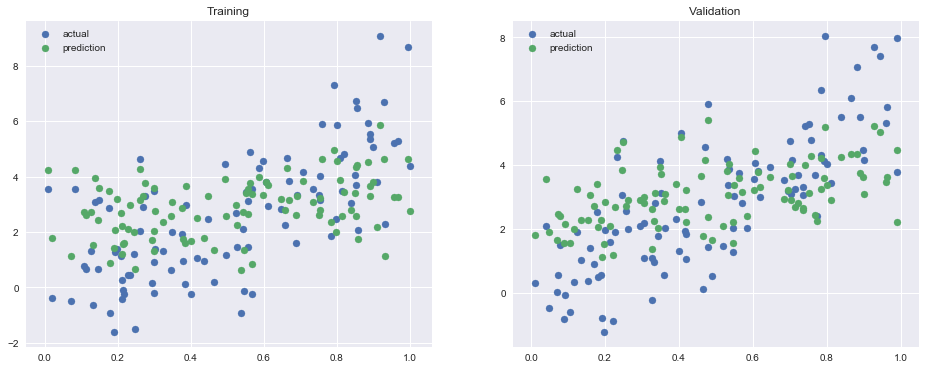

Epoch 200, Training loss 0.8622, Validation loss 0.7697


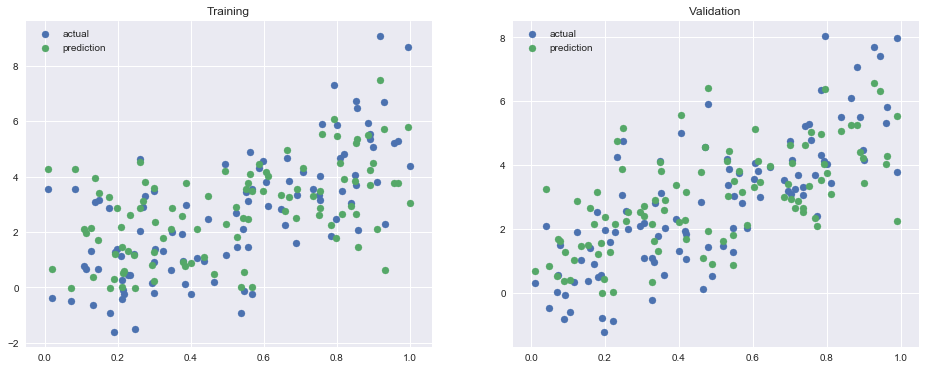

Epoch 300, Training loss 0.4325, Validation loss 0.3872


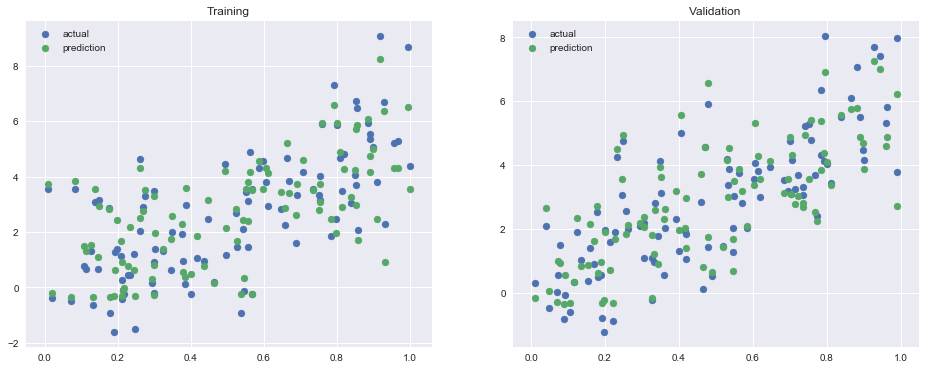

Epoch 400, Training loss 0.3315, Validation loss 0.309


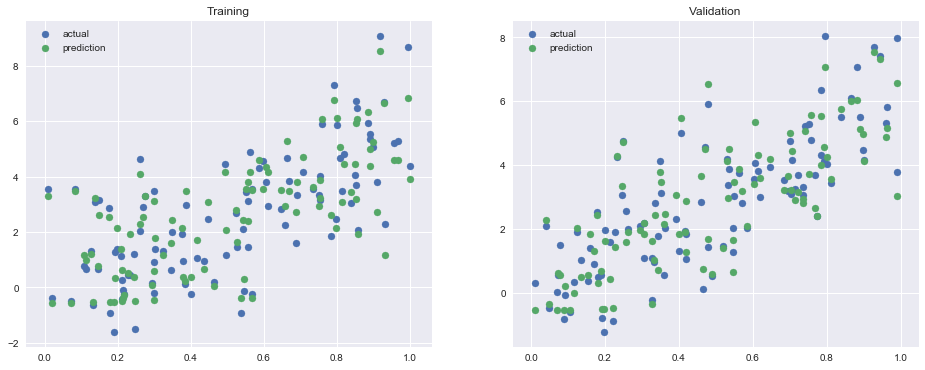

Epoch 500, Training loss 0.3132, Validation loss 0.3004


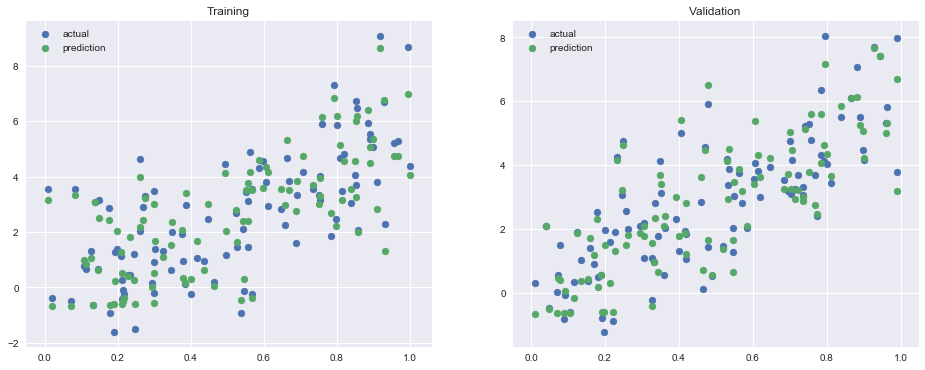

In [15]:
X_data = X_train_ts
y_data = y_train_ts

X_data_val = X_test_ts
y_data_val = y_test_ts

n_epoch = 500

train_loss, val_loss = [],[]

for epoch in range(1, n_epoch + 1):
    y_pred = ffnet(X_data)    
    epoch_loss_train = loss_func(y_pred, y_data) 
    
    y_pred_val = ffnet(X_data_val)
    epoch_loss_val = loss_func(y_pred_val, y_data_val)     
    
    optimizer.zero_grad()
    epoch_loss_train.backward()        
    optimizer.step()       
    
    train_loss.append(epoch_loss_train)
    val_loss.append(epoch_loss_val)
    
    #if epoch <= 5 or epoch % 100 == 0:
    if epoch % 100 == 0:
        print('Epoch {}, Training loss {}, Validation loss {}'.format(epoch, round(float(epoch_loss_train),4), round(float(epoch_loss_val),4)))
        
        #plt.cla()
        
        fig = plt.figure(figsize=(16,6))
        plt.subplot(1, 2, 1)
        plt.scatter(X_train.iloc[:,0], y_train, label="actual")
        plt.scatter(X_train.iloc[:,0], y_pred.detach().numpy(), label="prediction")
        plt.title("Training")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.scatter(X_test.iloc[:,0], y_test, label="actual")
        plt.scatter(X_test.iloc[:,0], y_pred_val.detach().numpy(),label="prediction")
        plt.title("Validation")
        plt.legend()
        
        #plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 10, 'color':  'red'})
        #plt.pause(0.1)

        plt.show()

## Plot loss curves

Text(0.5, 1.0, 'Training and Validation Loss Curves')

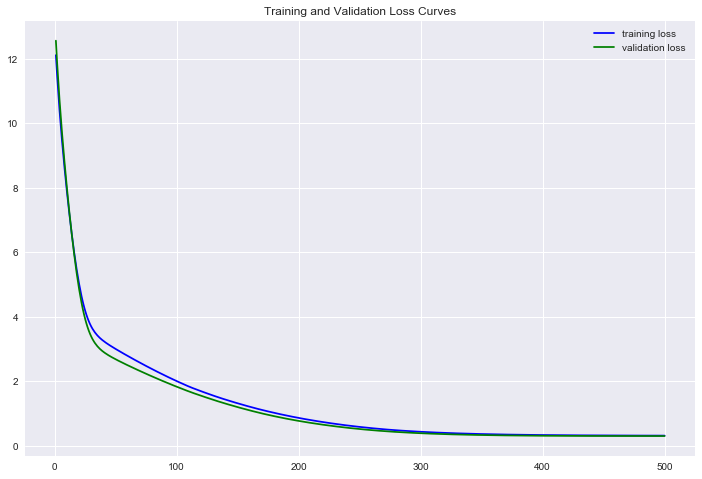

In [16]:
fig = plt.figure(figsize=(12,8))
plt.plot(range(1,len(train_loss)+1),train_loss,'b',label = 'training loss')
plt.plot(range(1,len(val_loss)+1),val_loss,'g',label = 'validation loss')
plt.legend()
plt.title("Training and Validation Loss Curves")

# Example 2: Feedforward Network With a Dropout Layer

In [17]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class ffNet(nn.Module):
    """
    D_in: input dimension
    D_h1: dimension of hidden layer 1
    D_out: output dimension
    """
    
    def __init__(self, D_in, D_h1, D_h2, D_out):
        super(ffNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, D_h1)
        self.linear1_drop = torch.nn.Dropout(p=0.8)
        self.linear2 = torch.nn.Linear(D_h1, D_out)

    def forward(self, x):
        h1 = F.relu(self.linear1(x))
        y_pred = self.linear2(h1)
        return y_pred

## Construct the model by instantiating the class defined above

In [18]:
# Construct the model by instantiating the class defined above
D_in = X_train.shape[1]
D_h1, D_h2 = 8,4
D_out = 1

ffnet = ffNet(D_in, D_h1, D_h2, D_out)
print(ffnet)

ffNet(
  (linear1): Linear(in_features=2, out_features=8, bias=True)
  (linear1_drop): Dropout(p=0.8)
  (linear2): Linear(in_features=8, out_features=1, bias=True)
)


## Define loss function and optimization algorithm

In [19]:
# Define Optimizer and Loss Function

#optimizer = torch.optim.SGD(ffnet.parameters(), lr=0.01, weight_decay=1e-4)
optimizer = torch.optim.SGD(ffnet.parameters(), lr=0.01)

loss_func = torch.nn.MSELoss()

## Model Training

Epoch 100, Training loss 1.1627, Validation loss 1.0141


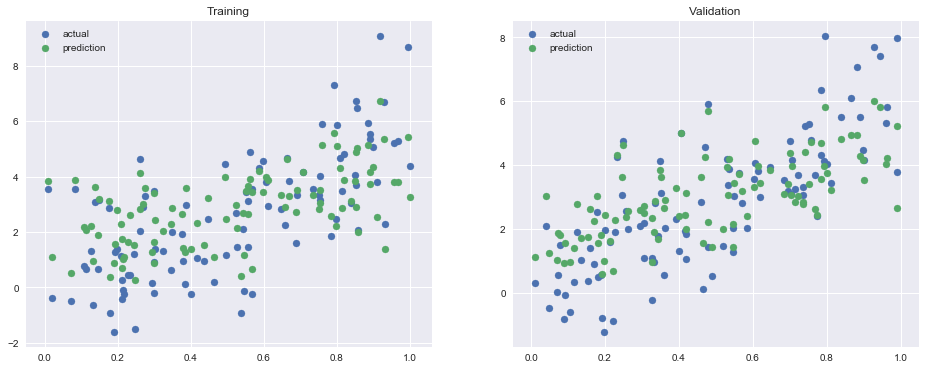

Epoch 200, Training loss 0.5, Validation loss 0.4372


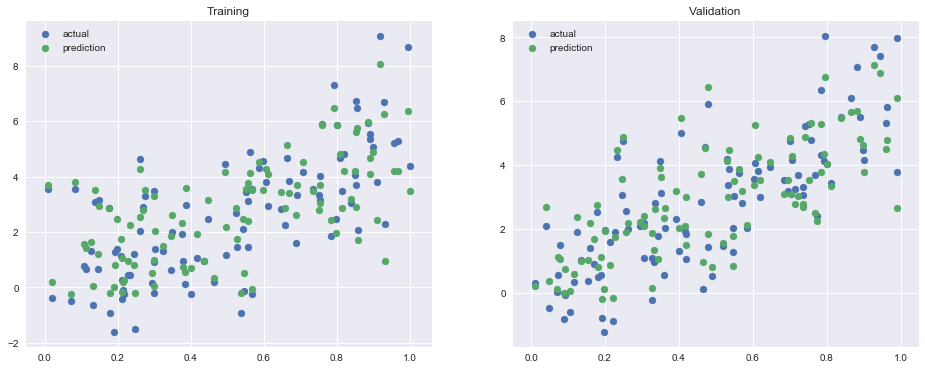

Epoch 300, Training loss 0.3468, Validation loss 0.3187


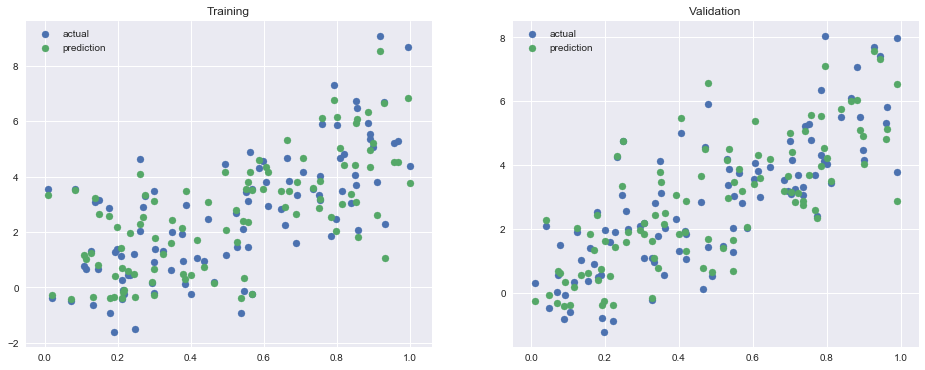

Epoch 400, Training loss 0.3157, Validation loss 0.3022


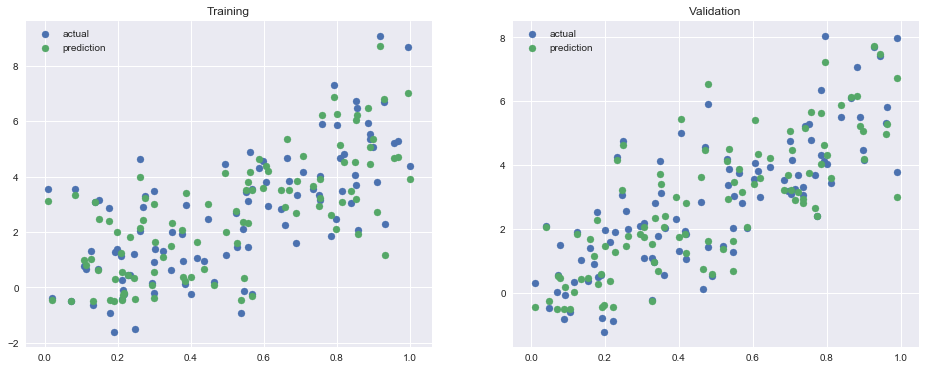

Epoch 500, Training loss 0.307, Validation loss 0.299


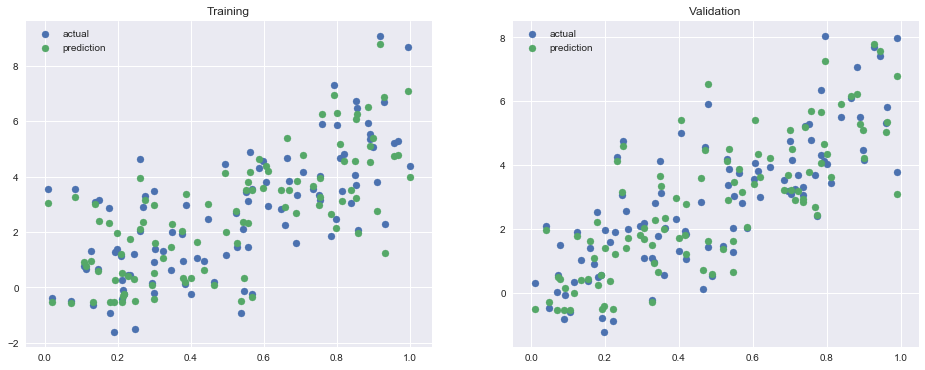

In [20]:
X_data = X_train_ts
y_data = y_train_ts

X_data_val = X_test_ts
y_data_val = y_test_ts

n_epoch = 500

train_loss, val_loss = [],[]

for epoch in range(1, n_epoch + 1):
    y_pred = ffnet(X_data)    
    epoch_loss_train = loss_func(y_pred, y_data) 
    
    y_pred_val = ffnet(X_data_val)
    epoch_loss_val = loss_func(y_pred_val, y_data_val)     
    
    optimizer.zero_grad()
    epoch_loss_train.backward()        
    optimizer.step()       
    
    train_loss.append(epoch_loss_train)
    val_loss.append(epoch_loss_val)
    
    #if epoch <= 5 or epoch % 100 == 0:
    if epoch % 100 == 0:
        print('Epoch {}, Training loss {}, Validation loss {}'.format(epoch, round(float(epoch_loss_train),4), round(float(epoch_loss_val),4)))
        
        #plt.cla()
        
        fig = plt.figure(figsize=(16,6))
        plt.subplot(1, 2, 1)
        plt.scatter(X_train.iloc[:,0], y_train, label="actual")
        plt.scatter(X_train.iloc[:,0], y_pred.detach().numpy(), label="prediction")
        plt.title("Training")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.scatter(X_test.iloc[:,0], y_test, label="actual")
        plt.scatter(X_test.iloc[:,0], y_pred_val.detach().numpy(),label="prediction")
        plt.title("Validation")
        plt.legend()
        
        #plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 10, 'color':  'red'})
        #plt.pause(0.1)

        plt.show()

## Plot loss curves

Text(0.5, 1.0, 'Training and Validation Loss Curves')

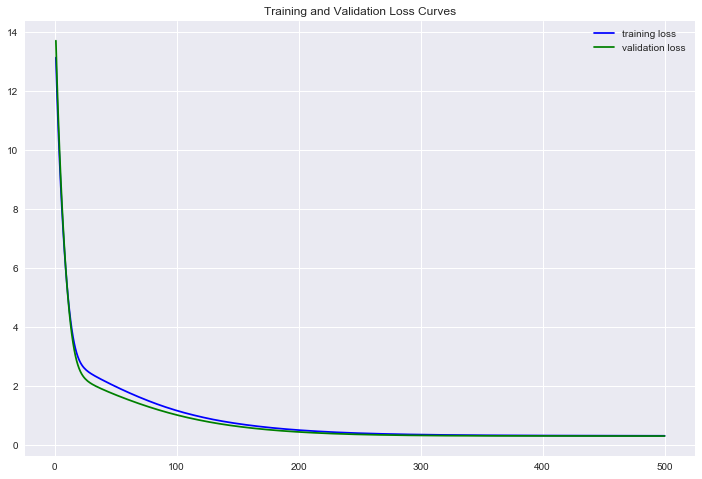

In [21]:
fig = plt.figure(figsize=(12,8))
plt.plot(range(1,len(train_loss)+1),train_loss,'b',label = 'training loss')
plt.plot(range(1,len(val_loss)+1),val_loss,'g',label = 'validation loss')
plt.legend()
plt.title("Training and Validation Loss Curves")

# Lab 3

In this lab, you will replicate the above exercise with a different simulated dataset. 

## Simulate and Visualize Data

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

n = 200 # number of examples (or observations)

# Generate a set of n random numbers from a standard normal distribution
epsilon = np.random.randn(n)

# Generate a set of n random numbers from a uniform[0,1] distribution; name it x1
# and create another variable, which we name x2, from x1
x1 = np.random.uniform(0,1,n)

X = pd.DataFrame({'x1':x1})

# Create the data generating mechanism
y = 1.5*x1 + np.power(x1,3)*np.exp(x1) + epsilon

## Split the data into a Training and Validation Set

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)

### Basic Descriptive Analysis

In [24]:
print(X_train.describe().T.round(4), "\n")
print(pd.DataFrame({'y':y_train}).describe().T.round(4))

    count    mean     std     min     25%     50%    75%     max
x1  100.0  0.4979  0.2896  0.0092  0.2557  0.4605  0.734  0.9937 

   count    mean     std     min     25%     50%     75%     max
y  100.0  1.3724  1.4893 -1.4268  0.3267  1.2445  2.2646  5.7261


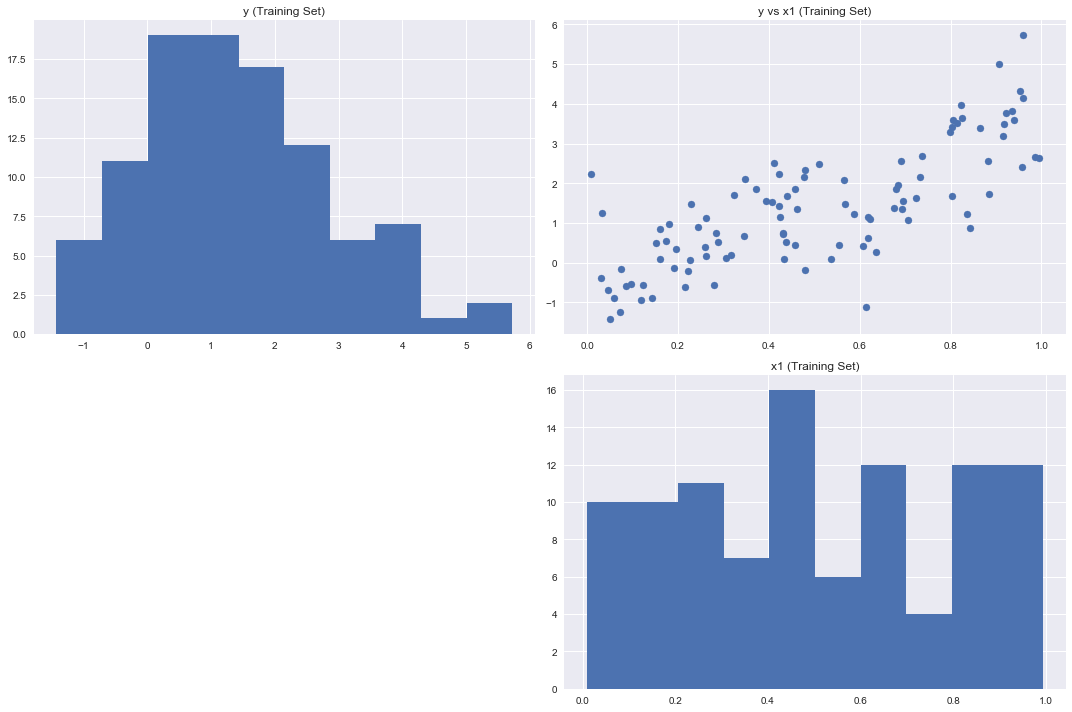

In [27]:
fig = plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.hist(y_train)
plt.title("y (Training Set)")

plt.subplot(2, 2, 2)
plt.scatter(X_train.iloc[:,0], y_train)
plt.title("y vs x1 (Training Set)")

plt.subplot(2, 2, 4)
plt.hist(X_train.iloc[:,0])
plt.title("x1 (Training Set)")

plt.tight_layout()

<div class="alert alert-block alert-warning">
Note: Before training, `numpy array` and `pandas dataframe` need to be converted to `PyTorch's tensors`
</div>

In [31]:
# convert numpy array to tensor in shape of input size
import torch 

X_train_ts = torch.from_numpy(X_train.values.reshape(-1,1)).float()
y_train_ts = torch.from_numpy(y_train.reshape(-1,1)).float()

X_test_ts = torch.from_numpy(X_test.values.reshape(-1,1)).float()
y_test_ts = torch.from_numpy(y_test.reshape(-1,1)).float() # y_test is a numpy array

In [32]:
print("X_train_ts is of %s type" %type(X_train_ts))
print("y_train_ts is of %s type" %type(y_train_ts))
print("X_test_ts is of %s type" %type(X_test_ts))
print("y_test_ts is of %s type" %type(y_test_ts))

X_train_ts is of <class 'torch.Tensor'> type
y_train_ts is of <class 'torch.Tensor'> type
X_test_ts is of <class 'torch.Tensor'> type
y_test_ts is of <class 'torch.Tensor'> type


In [33]:
print(X_train_ts.shape)
print(y_train_ts.shape)
print(X_test_ts.shape)
print(y_test_ts.shape)

torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])


In [34]:
# First 5 rows of tensor X
print("First 5 rows of tensor X_train_ts", "\n",  X_train_ts[:5], "\n")
print("First 5 rows of tensor y_train_ts", "\n",  y_train_ts[:5], "\n")

First 5 rows of tensor X_train_ts 
 tensor([[0.9593],
        [0.6234],
        [0.4339],
        [0.3054],
        [0.8020]]) 

First 5 rows of tensor y_train_ts 
 tensor([[4.1349],
        [1.1082],
        [0.1008],
        [0.1201],
        [1.6889]]) 



## Define a Feed-forward network with 1 hidden layers

In [35]:
# Let's confirm the dimensions of the inputs and outpu
print("train_size: ", len(X_train_ts), "\n")
print("X shape:", X_train_ts.shape, "\n")
print("y shape:", y_train_ts.shape, "\n")
print(X_train_ts.shape[1])

train_size:  100 

X shape: torch.Size([100, 1]) 

y shape: torch.Size([100, 1]) 

1


In [36]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class ffNet(nn.Module):
    """
    D_in: input dimension
    D_h1: dimension of hidden layer 1
    D_out: output dimension
    """
    
    def __init__(self, D_in, D_h1, D_out):
        super(ffNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, D_h1)
        self.linear2 = torch.nn.Linear(D_h1, D_out)

    def forward(self, x):
        h1 = F.relu(self.linear1(x))
        y_pred = self.linear2(h1)
        return y_pred

## Construct the model by instantiating the class defined above

In [37]:
X_train.shape[1]

1

In [38]:
# Construct the model by instantiating the class defined above
D_in = X_train.shape[1]
D_h1 = 8
D_out = 1

ffnet = ffNet(D_in, D_h1, D_out)
print(ffnet)

ffNet(
  (linear1): Linear(in_features=1, out_features=8, bias=True)
  (linear2): Linear(in_features=8, out_features=1, bias=True)
)


## Define loss function and optimization algorithm

In [39]:
# Define Optimizer and Loss Function

optimizer = torch.optim.SGD(ffnet.parameters(), lr=0.01)

loss_func = torch.nn.MSELoss()

## Model Training

Epoch 100, Training loss 0.8959, Validation loss 1.0568


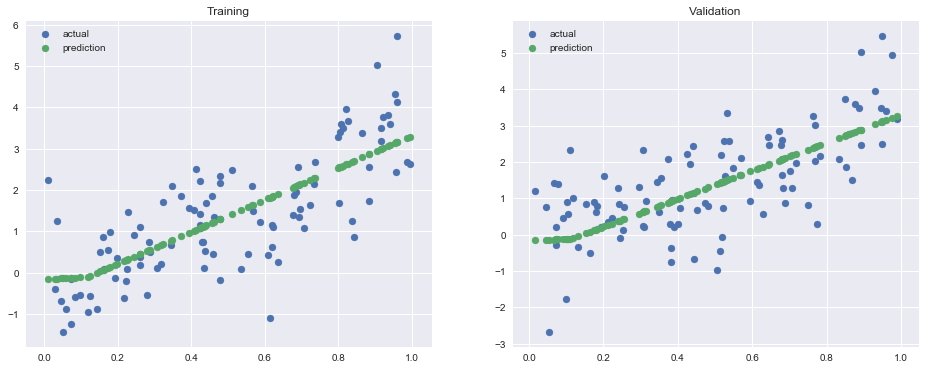

Epoch 200, Training loss 0.8932, Validation loss 1.065


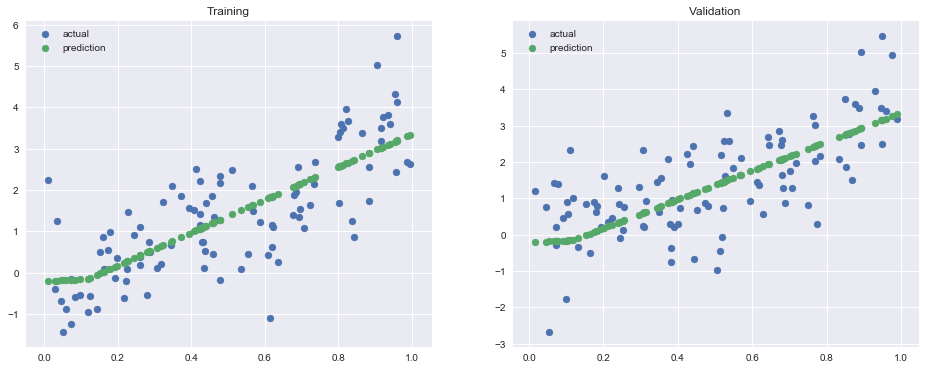

Epoch 300, Training loss 0.8925, Validation loss 1.0697


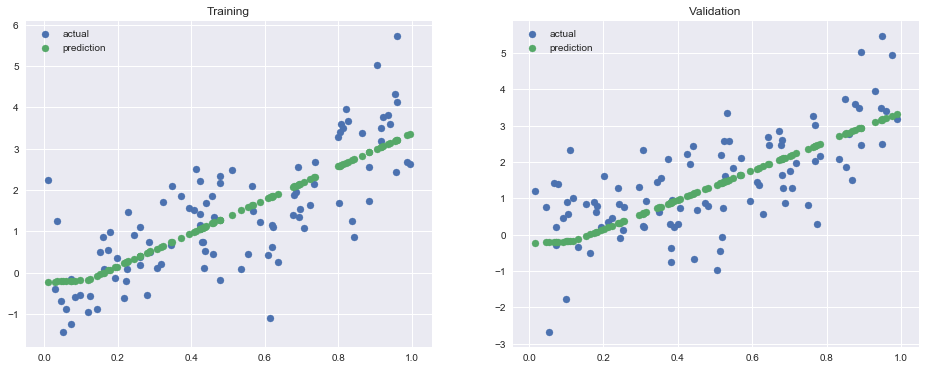

Epoch 400, Training loss 0.8923, Validation loss 1.0723


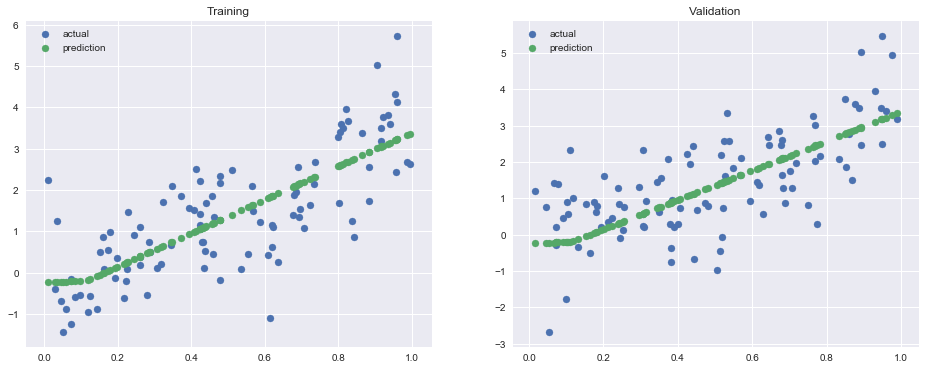

Epoch 500, Training loss 0.8922, Validation loss 1.0737


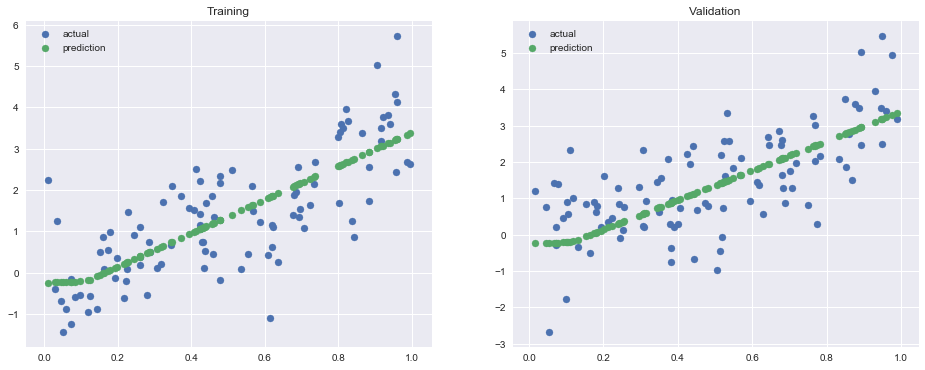

Epoch 600, Training loss 0.8922, Validation loss 1.0745


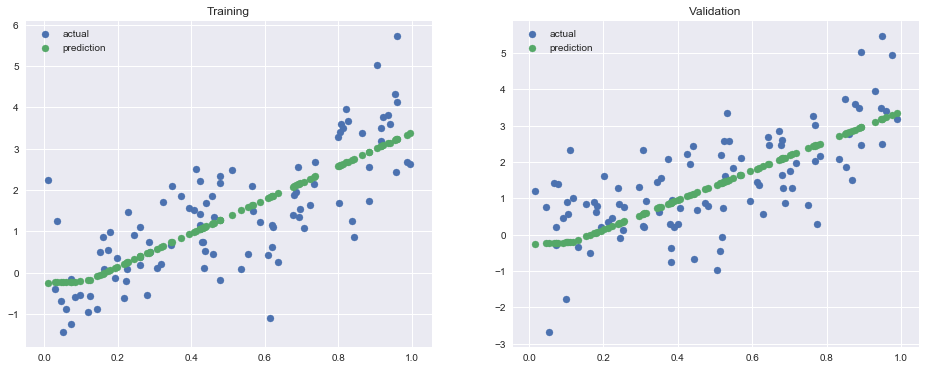

Epoch 700, Training loss 0.8921, Validation loss 1.075


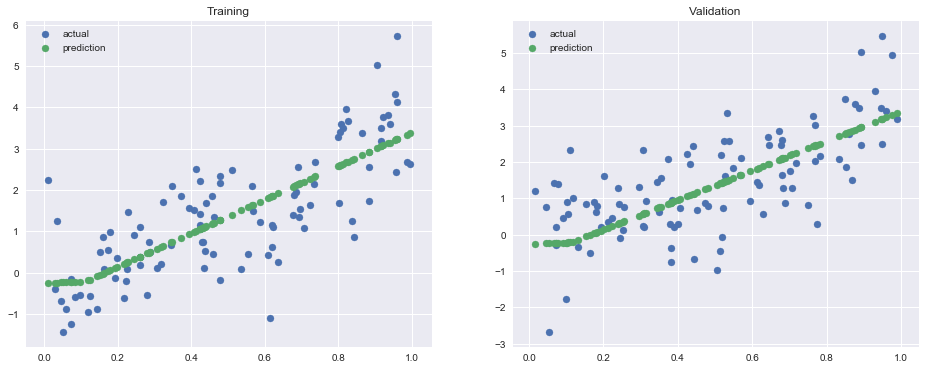

Epoch 800, Training loss 0.8921, Validation loss 1.0754


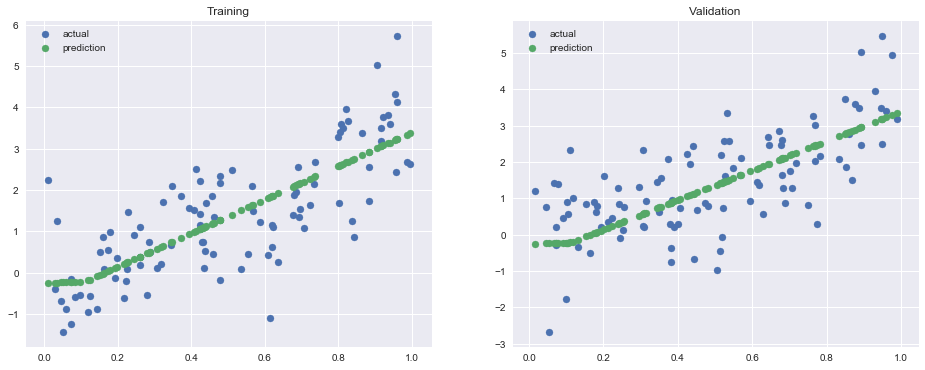

Epoch 900, Training loss 0.8921, Validation loss 1.0757


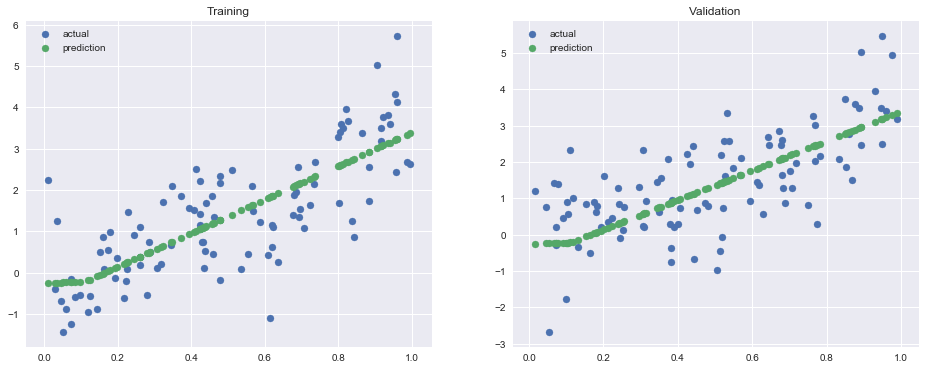

Epoch 1000, Training loss 0.892, Validation loss 1.0759


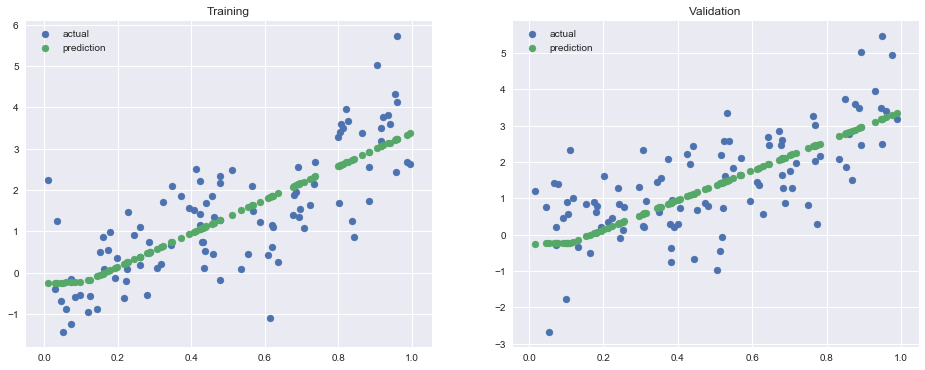

In [41]:
X_data = X_train_ts
y_data = y_train_ts

X_data_val = X_test_ts
y_data_val = y_test_ts

n_epoch = 1000

train_loss, val_loss = [],[]

for epoch in range(1, n_epoch + 1):
    y_pred = ffnet(X_data)    
    epoch_loss_train = loss_func(y_pred, y_data) 
    
    y_pred_val = ffnet(X_data_val)
    epoch_loss_val = loss_func(y_pred_val, y_data_val)     
    
    optimizer.zero_grad()
    epoch_loss_train.backward()        
    optimizer.step()       
    
    train_loss.append(epoch_loss_train)
    val_loss.append(epoch_loss_val)
    
    #if epoch <= 5 or epoch % 100 == 0:
    if epoch % 100 == 0:
        print('Epoch {}, Training loss {}, Validation loss {}'.format(epoch, round(float(epoch_loss_train),4), round(float(epoch_loss_val),4)))
        
        #plt.cla()
        
        fig = plt.figure(figsize=(16,6))
        plt.subplot(1, 2, 1)
        plt.scatter(X_train.iloc[:,0], y_train, label="actual")
        plt.scatter(X_train.iloc[:,0], y_pred.detach().numpy(), label="prediction")
        plt.title("Training")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.scatter(X_test.iloc[:,0], y_test, label="actual")
        plt.scatter(X_test.iloc[:,0], y_pred_val.detach().numpy(),label="prediction")
        plt.title("Validation")
        plt.legend()
        
        #plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 10, 'color':  'red'})
        #plt.pause(0.1)

        plt.show()

## Plot loss curves

Text(0.5, 1.0, 'Training and Validation Loss Curves')

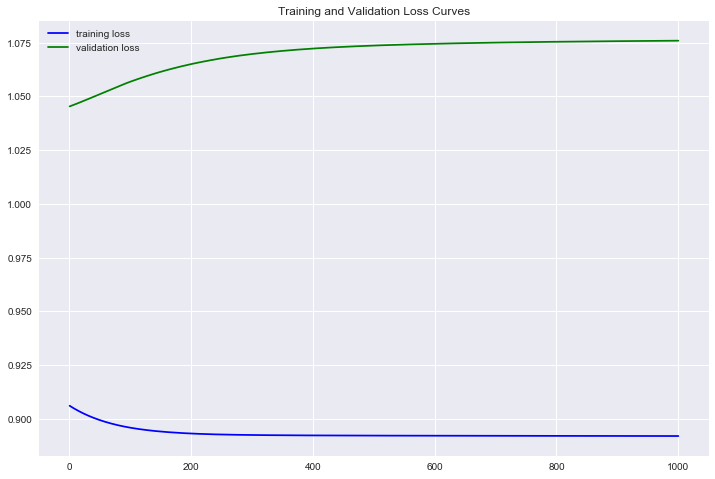

In [42]:
fig = plt.figure(figsize=(12,8))
plt.plot(range(1,len(train_loss)+1),train_loss,'b',label = 'training loss')
plt.plot(range(1,len(val_loss)+1),val_loss,'g',label = 'validation loss')
plt.legend()
plt.title("Training and Validation Loss Curves")

# Feedforward Network With a Dropout Layer

In [43]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class ffNet(nn.Module):
    """
    D_in: input dimension
    D_h1: dimension of hidden layer 1
    D_out: output dimension
    """
    
    def __init__(self, D_in, D_h1, D_out):
        super(ffNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, D_h1)
        self.linear1_drop = torch.nn.Dropout(p=0.8)
        self.linear2 = torch.nn.Linear(D_h1, D_out)

    def forward(self, x):
        h1 = F.relu(self.linear1(x))
        y_pred = self.linear2(h1)
        return y_pred

## Construct the model by instantiating the class defined above

In [44]:
# Construct the model by instantiating the class defined above
D_in = X_train.shape[1]
D_h1  = 8
D_out = 1

ffnet = ffNet(D_in, D_h1, D_out)
print(ffnet)

ffNet(
  (linear1): Linear(in_features=1, out_features=8, bias=True)
  (linear1_drop): Dropout(p=0.8)
  (linear2): Linear(in_features=8, out_features=1, bias=True)
)


## Define loss function and optimization algorithm

In [45]:
# Define Optimizer and Loss Function

#optimizer = torch.optim.SGD(ffnet.parameters(), lr=0.01, weight_decay=1e-4)
optimizer = torch.optim.SGD(ffnet.parameters(), lr=0.01)

loss_func = torch.nn.MSELoss()

## Model Training

Epoch 100, Training loss 1.6558, Validation loss 1.5023


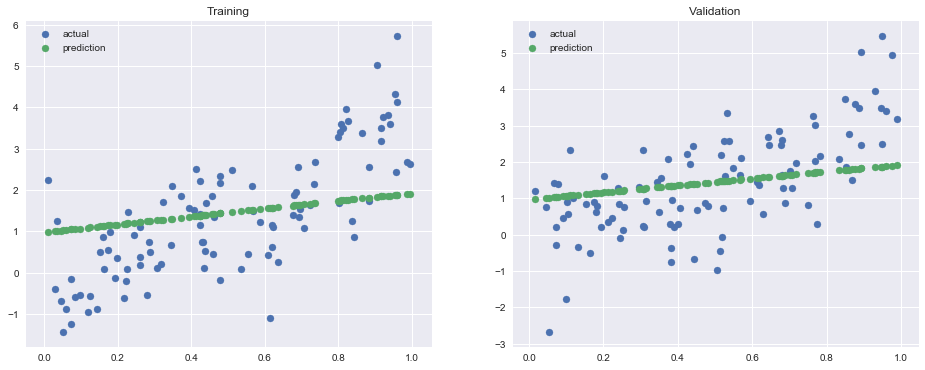

Epoch 200, Training loss 1.2412, Validation loss 1.2074


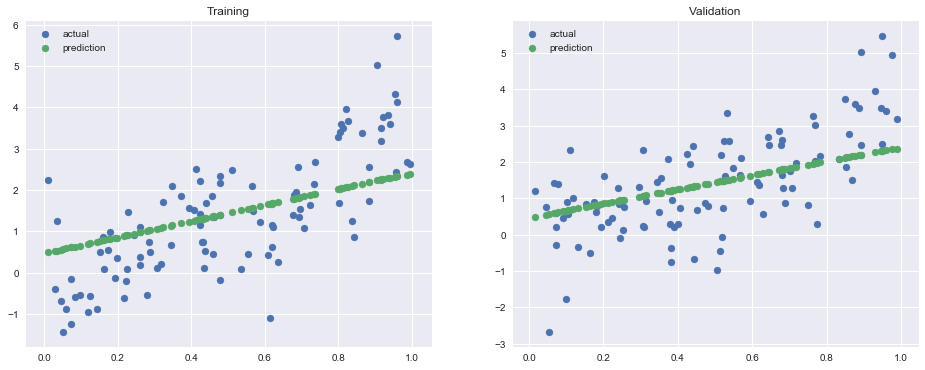

Epoch 300, Training loss 1.0028, Validation loss 1.0706


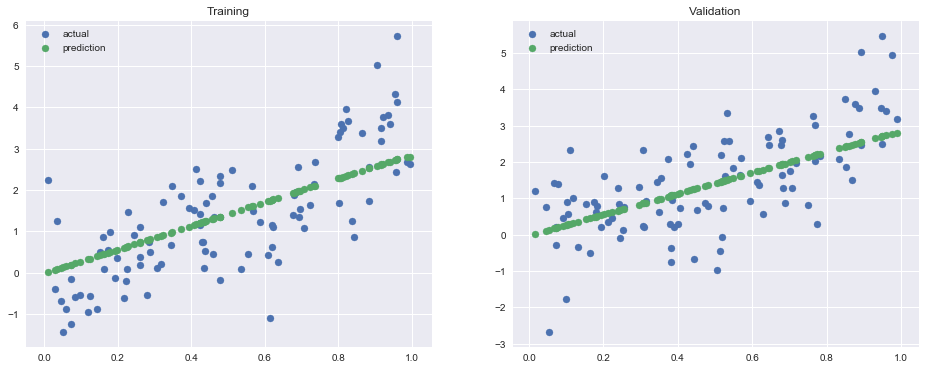

Epoch 400, Training loss 0.9256, Validation loss 1.0538


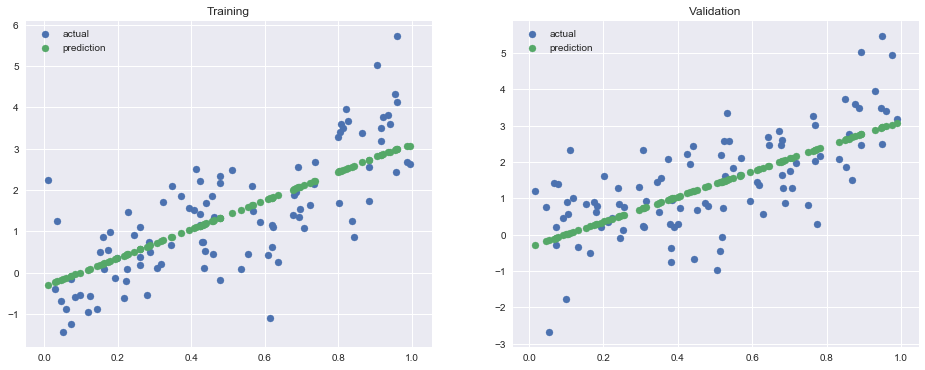

Epoch 500, Training loss 0.9097, Validation loss 1.0654


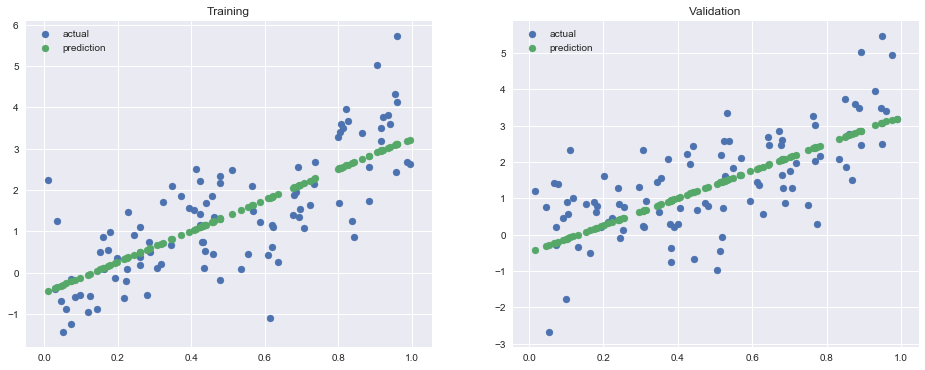

Epoch 600, Training loss 0.9071, Validation loss 1.0737


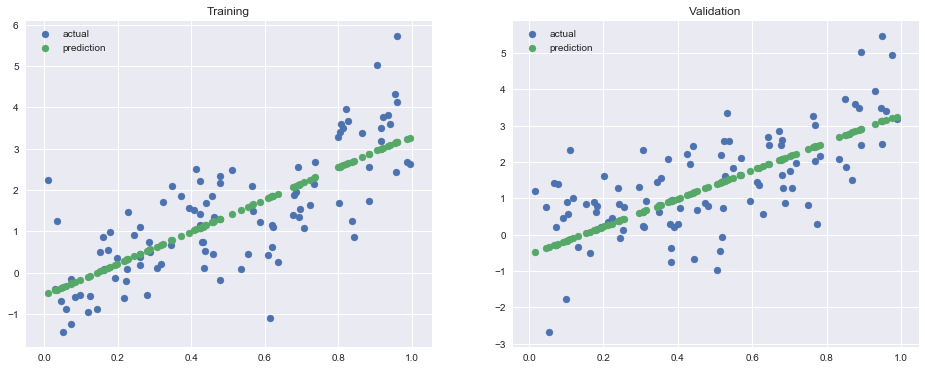

Epoch 700, Training loss 0.9067, Validation loss 1.0773


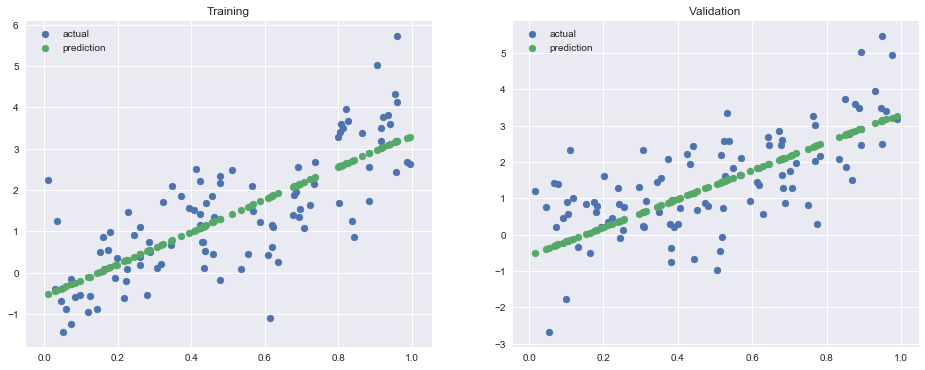

Epoch 800, Training loss 0.9066, Validation loss 1.0787


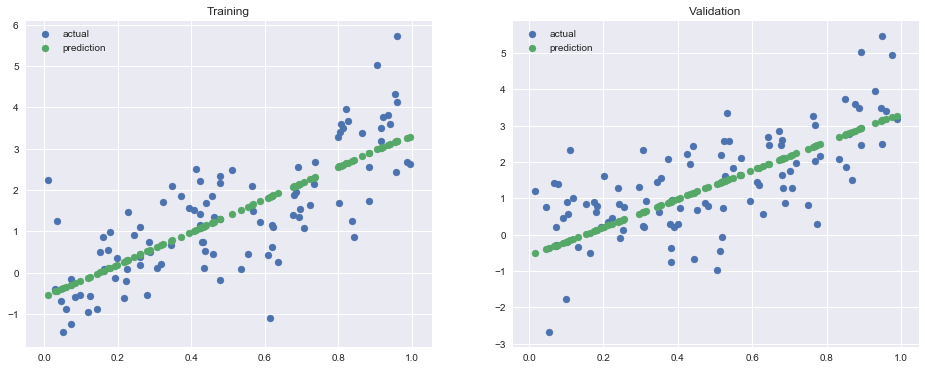

Epoch 900, Training loss 0.9065, Validation loss 1.0792


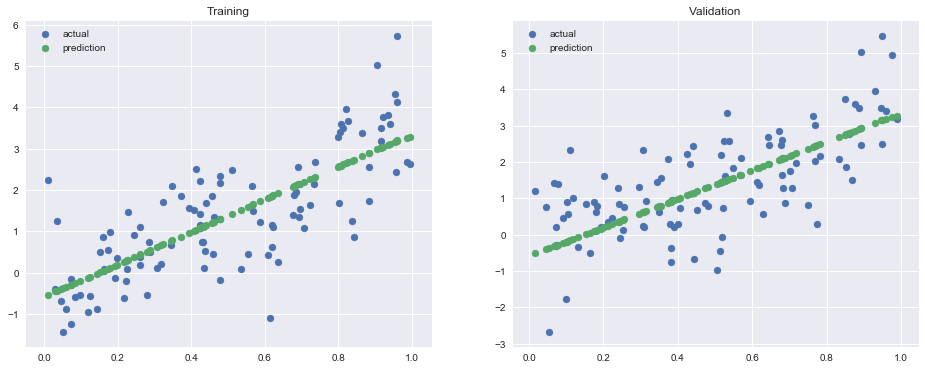

Epoch 1000, Training loss 0.9065, Validation loss 1.0793


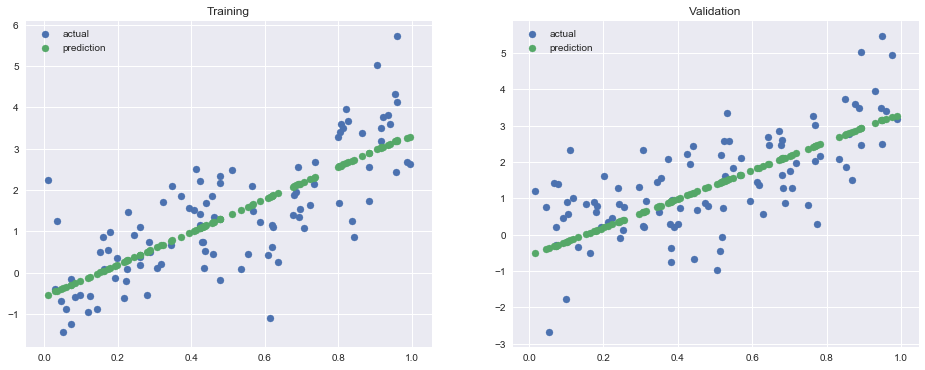

In [46]:
X_data = X_train_ts
y_data = y_train_ts

X_data_val = X_test_ts
y_data_val = y_test_ts

n_epoch = 1000

train_loss, val_loss = [],[]

for epoch in range(1, n_epoch + 1):
    y_pred = ffnet(X_data)    
    epoch_loss_train = loss_func(y_pred, y_data) 
    
    y_pred_val = ffnet(X_data_val)
    epoch_loss_val = loss_func(y_pred_val, y_data_val)     
    
    optimizer.zero_grad()
    epoch_loss_train.backward()        
    optimizer.step()       
    
    train_loss.append(epoch_loss_train)
    val_loss.append(epoch_loss_val)
    
    #if epoch <= 5 or epoch % 100 == 0:
    if epoch % 100 == 0:
        print('Epoch {}, Training loss {}, Validation loss {}'.format(epoch, round(float(epoch_loss_train),4), round(float(epoch_loss_val),4)))
        
        #plt.cla()
        
        fig = plt.figure(figsize=(16,6))
        plt.subplot(1, 2, 1)
        plt.scatter(X_train.iloc[:,0], y_train, label="actual")
        plt.scatter(X_train.iloc[:,0], y_pred.detach().numpy(), label="prediction")
        plt.title("Training")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.scatter(X_test.iloc[:,0], y_test, label="actual")
        plt.scatter(X_test.iloc[:,0], y_pred_val.detach().numpy(),label="prediction")
        plt.title("Validation")
        plt.legend()
        
        #plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 10, 'color':  'red'})
        #plt.pause(0.1)

        plt.show()

## Plot loss curves

Text(0.5, 1.0, 'Training and Validation Loss Curves')

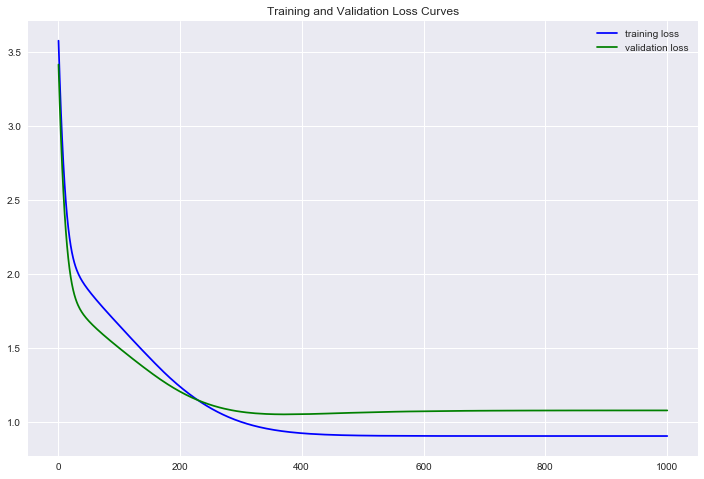

In [47]:
fig = plt.figure(figsize=(12,8))
plt.plot(range(1,len(train_loss)+1),train_loss,'b',label = 'training loss')
plt.plot(range(1,len(val_loss)+1),val_loss,'g',label = 'validation loss')
plt.legend()
plt.title("Training and Validation Loss Curves")